# 样本聚类
[大图](cluster.html), [下载](origin_files/cluster.ipynb)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
iris = datasets.load_iris()
data=iris.data
# pd.set_option('display.max_columns', 10)

In [2]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn import cluster
from sklearn.cluster import KMeans,AgglomerativeClustering

In [3]:
pca_scaled_data=PCA(n_components=2,whiten=True).fit_transform(data)
fa_scaled_data=FactorAnalysis(n_components=2).fit_transform(data)

## ward法

In [4]:
ward = AgglomerativeClustering(n_clusters=3, linkage='ward', compute_full_tree=True)
ward.fit(iris.data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree=True,
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func=<function mean at 0x0000020ED231D158>)

使用scipy中层次聚类函数：

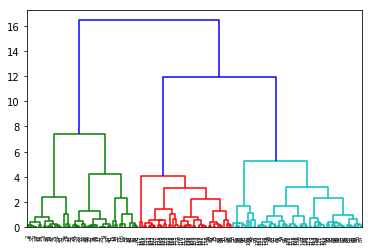

In [5]:
import scipy.cluster.hierarchy as sch

disMat = sch.distance.pdist(pca_scaled_data, 'euclidean') # 生成距离矩阵
Z = sch.linkage(disMat, method='ward')   # 进行层次聚类
P = sch.dendrogram(Z)   #  将层级聚类结果以树状图表示出来
# plt.savefig('plot_dendrogram1.png')  # 可保存图片

## K-MEASN聚类

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

建模：

In [6]:
kmeans = KMeans(n_clusters=3, n_init=15) #15次聚类
kmeans.fit(pca_scaled_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=15, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [7]:
labels=kmeans.labels_#原样本被分配到哪个类
kmeans.predict(pca_scaled_data)#新样本所在的类
kmeans.cluster_centers_#聚类中心点

array([[ 0.33363353, -0.88828797],
       [-1.28270581,  0.43367288],
       [ 1.0116707 ,  0.70397049]])

## 聚类效果评估
- 画各种图
- 轮廓系数：不相似度
- ARI：已知“标准答案”

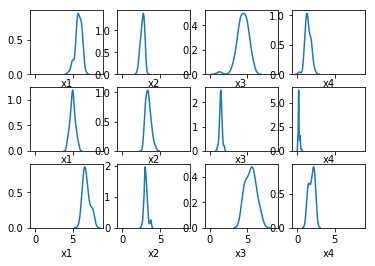

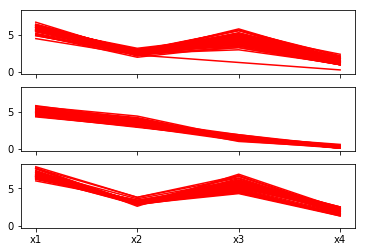

In [8]:
import seaborn as sns
k=3#聚成3类
n=4#2个feature
df=pd.DataFrame(data,columns=['x1','x2','x3','x4'])

fig, ax = plt.subplots(k, n, sharex=True)  # 共享x坐标的范围
for i in range(k):
    for j in range(n):
        sns.distplot(df.loc[labels == i, df.columns[j]], hist=False, ax=ax[i, j])

fig2, ax2 = plt.subplots(3, 1, sharex=True,sharey=True)
for i in range(3):
    data_temp = df.loc[labels == i, :]
    m_temp, n_temp = data_temp.shape
    for j in range(m_temp):
        ax2[i].plot(list(data_temp.iloc[j, :]), color='r')
        plt.xticks(range(n_temp), data_temp.columns)
plt.show()

因为没有标准化，所以图看起来不太好

- [轮廓系数 Silhouette Coefficient](http://scikit-learn.org/stable/modules/clustering.html#clustering)
- [ARI( Adjusted Rand index)](http://scikit-learn.org/stable/modules/clustering.html#clustering)

In [9]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

print('Sihouette:', silhouette_score(pca_scaled_data,  kmeans.labels_ ,metric='euclidean'))
print('ARI:', adjusted_rand_score(iris.target, kmeans.labels_ ))

Sihouette: 0.503209549336
ARI: 0.532145649791


## 改进
- 某些feature的重要性没那么高：pca、标准化
- feature的分布不合理，偏态分布，就用对数法、百分位秩、Turkey正态评分法，等等，使变成其变成近似正态分布
- kmeans处理不了非凸的情况

### 下面代码用到了pipeline

In [10]:
from sklearn.pipeline import Pipeline

steps = [('pca', PCA(n_components=1)), ('km', KMeans(n_clusters=3))]
pl = Pipeline(steps=steps)
pl.fit(iris.data)
print('Silhouette: ',silhouette_score(pl.named_steps['pca'].transform(iris.data),pl.predict(iris.data)))
print('ARI: ', adjusted_rand_score(iris.target, pl.predict(iris.data)))

Silhouette:  0.677166058432
ARI:  0.772631417041


### 使用标准化（standardization）/规范化（Normalization）做预处理——但需注意应用条件

standardization是对列，Normalization是对行

- 做标准化，不做降维：

In [11]:
from sklearn.preprocessing import Normalizer
steps2=[('Normalize',Normalizer()),['km',KMeans(n_clusters=3)]]
pl2=Pipeline(steps=steps2)
pl2.fit(iris.data)
print('Silhouette: ',silhouette_score(pl2.named_steps['Normalize'].transform(iris.data),pl2.predict(iris.data)))
print('ARI: ', adjusted_rand_score(iris.target, pl2.predict(iris.data)))

Silhouette:  0.576148277869
ARI:  0.903874231775


因为iris数据集量纲并不是差异巨大，所以聚类效果并不变更好

- 标准化+降维：

In [12]:
steps3=[('Normalize',Normalizer()),('pca',PCA(n_components=1)),['km',KMeans(n_clusters=3)]]
pl3=Pipeline(steps=steps3)
pl3.fit(iris.data)

print('Silhouette: ',silhouette_score(pl3.named_steps['pca'].transform(
    pl3.named_steps['Normalize'].transform(iris.data)),pl3.predict(iris.data)))

print('ARI: ', adjusted_rand_score(iris.target, pl3.predict(iris.data)))

Silhouette:  0.735607874078
ARI:  0.941044980074


## 高斯混合模型

In [13]:
from sklearn.mixture import GaussianMixture
pca_scaled_data=PCA(n_components=2).fit_transform(data)
gm = GaussianMixture(n_components=3, n_init=3)
gm.fit(pca_scaled_data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=3, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [14]:
gm.predict(pca_scaled_data)
gm.predict_proba(pca_scaled_data)
gm.bic(pca_scaled_data)

646.91993008979534

In [15]:
print('Silhouette: ',
      silhouette_score(pca_scaled_data, gm.predict(pca_scaled_data)))
print('ARI: ',
      adjusted_rand_score(iris.target, gm.predict(pca_scaled_data)))

Silhouette:  0.531265548291
ARI:  0.941044980074


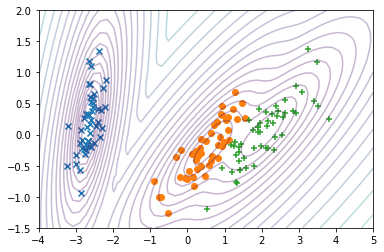

In [16]:
for cluster, marker in zip(range(3), ['x', 'o', '+']):
    x_axis = pca_scaled_data[:, 0][gm.predict(pca_scaled_data) == cluster]
    y_axis = pca_scaled_data[:, 1][gm.predict(pca_scaled_data) == cluster]
    plt.scatter(x_axis, y_axis, marker=marker)

x = np.linspace(-4., 5.)
y = np.linspace(-1.5, 2.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gm.score_samples(XX)
Z = Z.reshape(X.shape)

plt.contour(X, Y, Z, levels=np.logspace(0, 2, 20), alpha=0.3)

plt.show()

聚类个数的选择

In [17]:
cv_types = ['spherical', 'tied', 'diag', 'full']
ks = range(1, 7)
cv_bic = {}

for c in cv_types:
    k_bic = {}
    for k in ks:
        bic = GaussianMixture(n_components=k, covariance_type=c
                             ).fit(iris.data).bic(iris.data)
        k_bic[k] = bic
    cv_bic[c] = k_bic

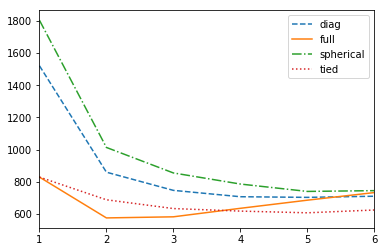

In [18]:
candidates = pd.DataFrame(cv_bic)
candidates.plot(style=['--', '-', '-.', ':'])

plt.show()

### 密度聚类

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN

In [19]:
from sklearn.cluster import DBSCAN
pca_scaled_data=PCA(n_components=2).fit_transform(data)
dbscan = DBSCAN(eps=0.3, min_samples=6)
dbscan.fit(pca_scaled_data)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=6, n_jobs=1, p=None)

In [20]:
dbscan.labels_#-1指的是孤立点

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,
        0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  2,  1,
        2,  2,  2, -1, -1, -1,  2, -1,  2,  2,  2,  1,  1,  2,  2, -1, -1,
        1,  2,  1, -1,  1,  2,  2,  1,  1,  2,  2,  2, -1,  2,  1,  1, -1,
        2,  2,  1,  2,  2,  2,  1,  2,  2,  2,  1,  2,  2,  1], dtype=int64)

In [21]:
from sklearn.metrics import adjusted_rand_score

print('ARI:', adjusted_rand_score(iris.target, dbscan.labels_))

ARI: 0.584245005698


In [22]:
mask = dbscan.labels_ > -1
print('ARI: ',adjusted_rand_score(iris.target[mask], dbscan.labels_[mask]))

ARI:  0.737165753698


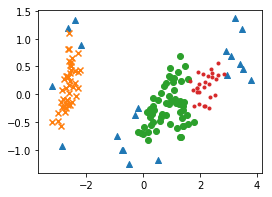

In [23]:
plt.figure(figsize=[4, 3])

for cluster, marker in zip(range(-1, 3), ['^', 'x', 'o', '.']):
    x_axis = pca_scaled_data[:, 0][dbscan.labels_ == cluster]
    y_axis = pca_scaled_data[:, 1][dbscan.labels_ == cluster]
    plt.scatter(x_axis, y_axis, marker=marker)

plt.show()

### 测试每种聚类的表现情况

http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#example-cluster-plot-cluster-comparison-py